In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv("./DataSet/train13519.csv")
df2 = pd.read_csv("./DataSet/train27303.csv")
df

,timestamp,hourly_traffic_count
0,2015-10-04 00:00:00,3
1,2015-10-04 00:05:00,12
2,2015-10-04 00:10:00,4
3,2015-10-04 00:15:00,9
4,2015-10-04 00:20:00,5
...,...,...
26491,2016-01-03 23:35:00,5
26492,2016-01-03 23:40:00,9
26493,2016-01-03 23:45:00,7
26494,2016-01-03 23:50:00,13


In [3]:
import glob

In [5]:
train = {}

for file in glob.iglob("./DataSet/*.csv"):
    id = file.split("/")[-1].replace("train", "").replace(".csv", "")
    train[id] = pd.read_csv(file)

train

{'20803':                  timestamp  hourly_traffic_count
 0      2015-10-04 00:00:00                     0
 1      2015-10-04 00:05:00                     0
 2      2015-10-04 00:10:00                     0
 3      2015-10-04 00:15:00                     0
 4      2015-10-04 00:20:00                     0
 ...                    ...                   ...
 26491  2016-01-03 23:35:00                     0
 26492  2016-01-03 23:40:00                     0
 26493  2016-01-03 23:45:00                     0
 26494  2016-01-03 23:50:00                     0
 26495  2016-01-03 23:55:00                     0
 
 [26496 rows x 2 columns],
 '14219':                  timestamp  hourly_traffic_count
 0      2015-10-04 00:00:00                    17
 1      2015-10-04 00:05:00                    50
 2      2015-10-04 00:10:00                    47
 3      2015-10-04 00:15:00                    39
 4      2015-10-04 00:20:00                    38
 ...                    ...                   ...
 26

In [8]:
n_out_steps = 12
n_in_steps = 3 * n_out_steps
n_locations = len(train)

n_out_steps, n_in_steps, n_locations # locations: total file numbers

(12, 36, 35)

In [10]:
#jump = 488
batches = []
for id in train:
    n = train[id].index.size
    jump = round(n/2)
    start = 0
    batch_i = -1
    while start < round(n-.5*jump):
        batch_i += 1
        batch = train[id].iloc[list(range(start, start+jump))]["hourly_traffic_count"]
        start += jump
        if len(batches) < batch_i + 1:
            batches.append([batch])
        else:
            batches[batch_i].append(batch)
for batch_i, batch in enumerate(batches):
    batches[batch_i] = list(zip(*batch))
    
batches

[[(0,
   17,
   8,
   10,
   0,
   6,
   22,
   0,
   11,
   27,
   0,
   0,
   2,
   0,
   7,
   21,
   3,
   9,
   37,
   12,
   7,
   113,
   48,
   12,
   7,
   28,
   5,
   0,
   0,
   3,
   44,
   16,
   7,
   20,
   6),
  (0,
   50,
   0,
   8,
   0,
   3,
   27,
   0,
   3,
   2,
   0,
   0,
   9,
   0,
   7,
   13,
   16,
   20,
   105,
   22,
   30,
   43,
   1,
   4,
   6,
   60,
   6,
   0,
   23,
   12,
   7,
   10,
   30,
   19,
   0),
  (0,
   47,
   0,
   21,
   0,
   4,
   29,
   0,
   6,
   6,
   0,
   1,
   7,
   0,
   10,
   13,
   9,
   15,
   93,
   20,
   37,
   31,
   0,
   1,
   10,
   66,
   5,
   0,
   13,
   4,
   10,
   5,
   47,
   14,
   8),
  (0,
   39,
   0,
   18,
   0,
   5,
   20,
   0,
   7,
   2,
   0,
   0,
   6,
   0,
   13,
   15,
   12,
   24,
   80,
   10,
   23,
   27,
   0,
   6,
   4,
   46,
   3,
   0,
   12,
   9,
   7,
   14,
   37,
   8,
   4),
  (0,
   38,
   0,
   12,
   1,
   1,
   30,
   0,
   3,
   5,
   0,
   0,
   4,
   0,
   7,


In [11]:
len(batches), len(batches[0]), len(batches[0][0])

(2, 13248, 35)

In [15]:
# Transform batches into actual train set.

X = []
Y = []
for batch_i, batch in enumerate(batches):
    x = []
    y = []
    for t in range(n_in_steps, len(batch)-n_out_steps):
        _x = batch[t-n_in_steps:t]
        x.append(np.array(_x))
        _y = np.sum(batch[t:t+n_out_steps], axis=0)
        y.append(np.array(_y))
    X.extend(x)
    Y.extend(y)

In [14]:
len(X), len(X[1]), len(X[0][0]), len(Y), len(Y[0])

(26400, 36, 35, 26400, 35)

In [16]:
train_X = [x for i, x in enumerate(X) if i % 2 == 0]
train_Y = [x for i, x in enumerate(Y) if i % 2 == 0]
test_X = [x for i, x in enumerate(X) if i % 2 == 1]
test_Y = [x for i, x in enumerate(Y) if i % 2 == 1]

from sklearn.preprocessing import StandardScaler, MinMaxScaler
normalizer_x = MinMaxScaler()
normalizer_x.fit(np.array(train_X).flatten().reshape(-1,1))
normalizer_y = MinMaxScaler()
normalizer_y.fit(np.array(train_Y).flatten().reshape(-1,1))
train_X = normalizer_x.transform(np.array(train_X).flatten().reshape(-1,1)).reshape(len(train_X), len(train_X[0]), len(train_X[0][0]))
train_Y = normalizer_y.transform(np.array(train_Y).flatten().reshape(-1,1)).reshape(len(train_Y), len(train_Y[0]))
test_X = normalizer_x.transform(np.array(test_X).flatten().reshape(-1,1)).reshape(len(test_X), len(test_X[0]), len(test_X[0][0]))
test_Y = normalizer_y.transform(np.array(test_Y).flatten().reshape(-1,1)).reshape(len(test_Y), len(test_Y[0]))

In [17]:
# split to two dataset
len(train_X), len(train_X[1]), len(train_X[1][1]), len(train_Y), len(train_Y[1]) 

(13200, 36, 35, 13200, 35)

In [23]:
# LSTM model
from tensorflow import keras
import math

def create_lstm_model():
    inputs = keras.layers.Input(shape=(n_in_steps, n_locations))
    l = inputs
    l = keras.layers.LSTM(n_locations)(l)
    l = keras.layers.Dense(n_locations)(l)
    outputs = l
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=0.001),
        loss="mean_absolute_error",
        metrics=["mean_absolute_percentage_error", "mean_squared_error"]
    )
    return model

In [24]:
lstm = create_lstm_model()
lstm.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 36, 35)]          0         
                                                                 
 lstm_3 (LSTM)               (None, 35)                9940      
                                                                 
 dense_3 (Dense)             (None, 35)                1260      
                                                                 
Total params: 11,200
Trainable params: 11,200
Non-trainable params: 0
_________________________________________________________________


In [22]:
import time
time1 = time.time()
lstm = create_lstm_model()
lstm.fit(np.array(train_X), np.array(train_Y), epochs=10, verbose=0)
time2 = time.time()
print("Execution time:", time2-time1)

2022-08-12 17:59:08.480304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 17:59:08.626557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 17:59:08.715920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Execution time: 62.74874711036682


In [25]:
lstm.evaluate(np.array(test_X), np.array(test_Y))

  7/413 [..............................] - ETA: 3s - loss: 0.1158 - mean_absolute_percentage_error: 8218366.0000 - mean_squared_error: 0.0283  

2022-08-12 18:01:23.065554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 18:01:23.113501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 4s 8ms/step - loss: 0.0854 - mean_absolute_percentage_error: 8503707.0000 - mean_squared_error: 0.0238


[0.08542852848768234, 8503707.0, 0.023761870339512825]

In [29]:
lstm_pred = lstm.predict(np.array(test_X))
lstm_pred = normalizer_y.inverse_transform(lstm_pred)
np.round(lstm_pred[50] * 1 + 0).astype(np.int)

413/413 [==============================] - 2s 5ms/step


/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/1009979728.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.round(lstm_pred[50] * 1 + 0).astype(np.int)


array([ -961,   774,   436,    55,   753,  -824,  -900,  -309,   116,
        -688,  -186,   445,     3,  -906,  -579,  -340,  -396,  -282,
        1025,  -483,    16,  -690,  -405,   474,  -496,    20,  -517,
       -1345, -1653,   -90,  -291,  -101,   935,   -84,   -75])

In [27]:
import copy
true = np.array(copy.deepcopy(test_Y))
true = normalizer_y.inverse_transform(true)
np.round(true[50]).astype(np.int)

/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/3304112223.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.round(true[50]).astype(np.int)


array([1331, 1275,    0,  509,    1,  240, 1081,    0,  320,  246,    0,
          0,  301,    0,  288, 1072,  515,  667, 3883,  795, 1250, 2003,
        771,  289,  183, 1887,  273,  553, 1210,  356,  371,  326, 1069,
        881,    0])

/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/1172687391.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/1172687391.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or 

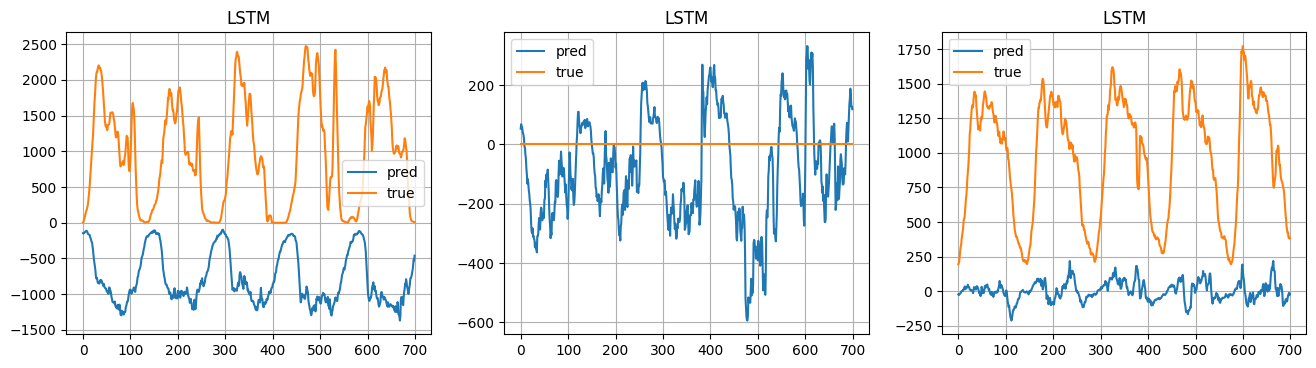

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 4), dpi=100)

location_id = 0
plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(131)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

location_id = 10
plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(132)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

location_id = 20
plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(133)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

plt.show()

In [30]:
# Stacked Autoencoder
from tensorflow import keras
import tensorflow.keras.backend as kb
import math
import tensorflow as tf

def sparse_regularizer(x):
    gamma = tf.convert_to_tensor(.1)
    rho = tf.convert_to_tensor(.001)
    rho2 = tf.reduce_mean(tf.math.abs(x))
    y = tf.math.add(tf.math.multiply(rho, tf.math.log(tf.math.divide(rho, rho2))), tf.math.multiply(tf.math.subtract(tf.constant(1.0), rho), tf.math.log(tf.math.divide(tf.math.subtract(tf.constant(1.0), rho), tf.math.subtract(tf.constant(1.0), rho2)))))
    return y

class SparseRegLayer(keras.layers.Layer):
    def __init__(self, layer):
        keras.layers.Layer.__init__(self)
        self.layer = layer
        
    def call(self, inputs):
        x = self.layer(inputs)
        self.add_loss(sparse_regularizer(x))
        return x

def create_autoencoder(input_size, hidden_size):
    inputs = keras.layers.Input(shape=(input_size,))
    l = inputs
    l = SparseRegLayer(keras.layers.Dense(hidden_size))(l)
    l = keras.layers.Dense(input_size)(l)
    outputs = l
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=0.001),
        loss="mean_absolute_error"
    )
    return model

def create_sae_model(hidden_sizes):
    inputs = keras.layers.Input(shape=(n_in_steps, n_locations))
    l = inputs
    ll = keras.layers.Flatten()
    l = ll(l)
    hidden = []
    prev_size = n_in_steps * n_locations
    X = np.array(train_X)
    for hidden_size in hidden_sizes:
        model1 = create_autoencoder(prev_size, hidden_size)
        X = ll(X)
        model1.fit(X, X, epochs=10, verbose=0)
        ll = model1.layers[1]
        hidden.append(ll)
        l = keras.layers.Dense(hidden_size, activation="relu")(l)
        prev_size = hidden_size
    l = keras.layers.Dense(n_locations)(l)
    outputs = l
    model = keras.Model(inputs=inputs, outputs=outputs)
    for layer_i, layer in enumerate(model.layers[2:-1]):
        layer.set_weights(hidden[layer_i].get_weights())
    model.compile(
        optimizer=keras.optimizers.Nadam(learning_rate=0.001),
        loss="mean_absolute_error",
        metrics=["mean_absolute_percentage_error", "mean_squared_error"]
    )
    return model

In [31]:
model = create_sae_model([100,100])
model.summary()

2022-08-12 18:51:54.116827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 18:52:20.122915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 36, 35)]          0         
                                                                 
 flatten (Flatten)           (None, 1260)              0         
                                                                 
 dense_6 (Dense)             (None, 100)               126100    
                                                                 
 dense_9 (Dense)             (None, 100)               10100     
                                                                 
 dense_10 (Dense)            (None, 35)                3535      
                                                                 
Total params: 139,735
Trainable params: 139,735
Non-trainable params: 0
_________________________________________________________________


In [32]:
import time
time1 = time.time()
model = create_sae_model([100, 100])
model.fit(np.array(train_X), np.array(train_Y), epochs=10, verbose=0)
time2 = time.time()
print("Execution time:", time2-time1)

2022-08-12 18:53:05.318794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 18:53:33.190005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 18:53:57.597720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Execution time: 82.99514603614807


In [33]:
np.array(model.evaluate(np.array(test_X), np.array(test_Y)))

 24/413 [>.............................] - ETA: 1s - loss: 0.0118 - mean_absolute_percentage_error: 1124050.0000 - mean_squared_error: 4.9883e-04

2022-08-12 18:56:12.991327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 2s 4ms/step - loss: 0.0084 - mean_absolute_percentage_error: 949799.4375 - mean_squared_error: 4.1022e-04


array([8.36330280e-03, 9.49799438e+05, 4.10217821e-04])

In [34]:
pred = model.predict(np.array(test_X))
pred = normalizer_y.inverse_transform(pred)
np.round(pred[50]).astype(np.int)

 86/413 [=====>........................] - ETA: 0s

2022-08-12 18:56:37.646416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


413/413 [==============================] - 1s 2ms/step


/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/2979905661.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.round(pred[50]).astype(np.int)


array([1573, 1159,   79,  442,  -32,  224,  874,    9,  233,  219,   -4,
        -16,  346,  -18,  323,  982,  484,  710, 4074,  850, 1170, 1963,
        804,  395,  182, 1897,  364,  668, 1101,  310,  359,  365,  930,
        914,   34])

In [35]:
import copy
true = np.array(copy.deepcopy(test_Y))
true = normalizer_y.inverse_transform(true)
np.round(true[50]).astype(np.int)

/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/3304112223.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.round(true[50]).astype(np.int)


array([1331, 1275,    0,  509,    1,  240, 1081,    0,  320,  246,    0,
          0,  301,    0,  288, 1072,  515,  667, 3883,  795, 1250, 2003,
        771,  289,  183, 1887,  273,  553, 1210,  356,  371,  326, 1069,
        881,    0])

/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/2543983310.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plot_pred = np.round(np.array([round(x[location_id]) for x in pred[:700]]) * 1 - 0).astype(np.int)
/var/folders/ld/vvyhl7992v716byfq7fgmbhm0000gn/T/ipykernel_14800/2543983310.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.i

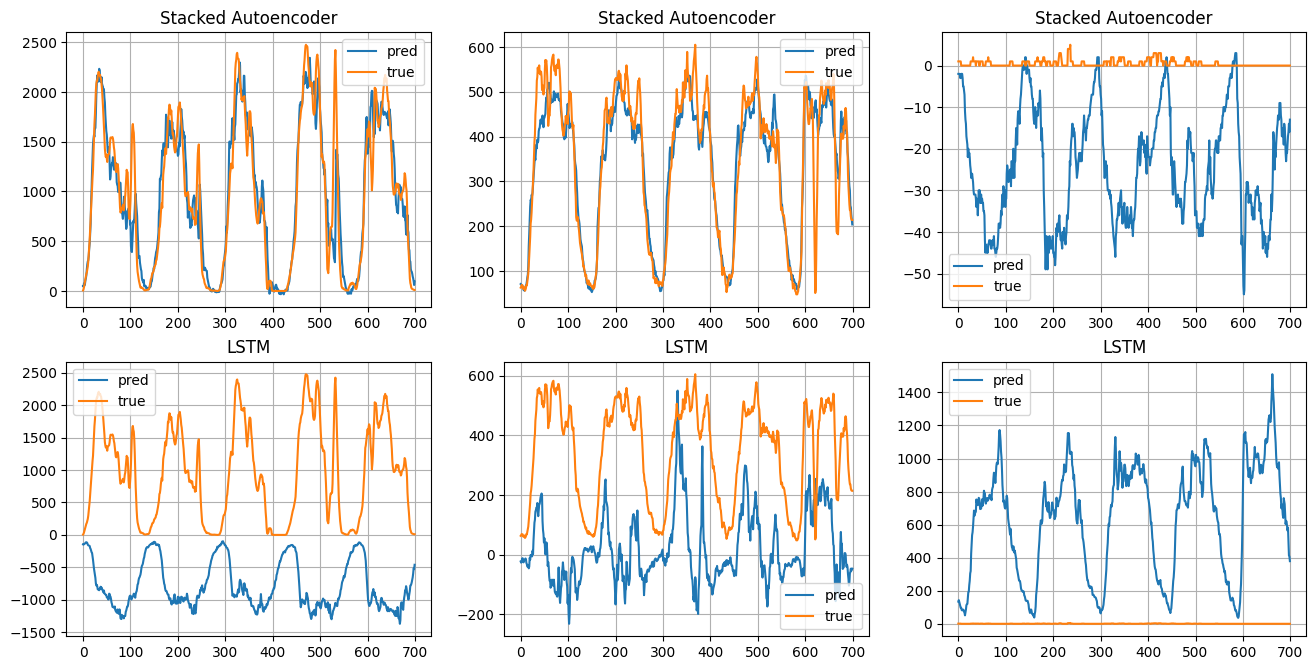

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8), dpi=100)

location_id = 0

plot_pred = np.round(np.array([round(x[location_id]) for x in pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(231)
plt.title("Stacked Autoencoder")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plt.subplot(234)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

location_id = 3

plot_pred = np.round(np.array([round(x[location_id]) for x in pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(232)
plt.title("Stacked Autoencoder")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plt.subplot(235)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

location_id = 4

plot_pred = np.round(np.array([round(x[location_id]) for x in pred[:700]]) * 1 - 0).astype(np.int)
plot_true = [round(x[location_id]) for x in true[:700]]
plt.subplot(233)
plt.title("Stacked Autoencoder")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

plot_pred = np.round(np.array([round(x[location_id]) for x in lstm_pred[:700]]) * 1 - 0).astype(np.int)
plt.subplot(236)
plt.title("LSTM")
plt.plot(plot_pred, label='pred')
plt.plot(plot_true, label='true')
plt.legend()
plt.grid(True)

plt.show()